In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("./phishingData.csv")
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
#for logistic regression
from sklearn.linear_model import LogisticRegression
#for knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#for Dtree
from sklearn.tree import DecisionTreeClassifier, plot_tree
#for NB
from sklearn.naive_bayes import GaussianNB
#for svm
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import SGDClassifier
#for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
df=df.drop(df.columns[0],axis=1)
df=df.dropna()

In [ ]:
def plot_graphs(category_value_pairs,titles):
    # determine the number of pairs
    num_pairs = len(category_value_pairs)
    
    # create subplots based on the number of pairs
    fig, axes = plt.subplots(1, num_pairs, figsize=(15, 5))  
    if len(category_value_pairs)==1:
        axes=[axes]

# Iterate over each pair of categories and value
    for i, (categories, values) in enumerate(category_value_pairs):
        ax = axes[i]
        bars = ax.bar(categories, values)
        # add labels to the bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.01, f'{yval:.2f}',
                    ha='center', va='bottom')
        ax.set_title(titles[i])    
    plt.tight_layout()
    plt.show()

#The scatter plot shows TP(1,1) TN(0,0) FP(1,0) FN(0,1) , the size indicates it’s values    
def plot_cf(y_pred,y_test):
    points = np.vstack((y_pred,y_test)).T  
    unique_points, counts = np.unique(points, axis=0, return_counts=True)
    scaling_factor = 6
    plt.scatter(unique_points[:, 0], unique_points[:, 1], s=counts * scaling_factor, alpha=0.9)
    labels = {(0,0): 'TN', (1,1): 'TP', (1,0): 'FP', (0,1): 'FN'}
    for point, count in zip(unique_points, counts):
        label = labels[tuple(point)]
        plt.text(point[0], point[1], f' {label}\n({count})', fontsize=12, ha='center')
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.grid(True)
    plt.show()

#To draw ROC graph 
def draw_roc_auc(y_test,y_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



In [12]:
#storing all models scores to use them for comparative analysis of all models
#we are using f1 score as scoring metric for our models since, our usecase needs to balance both precision and recall
#predicting a legitimate site as Phishing (FN) and a Phishing site as legitimate(FP) are both equally costly 
all_f1_scores={}
all_accuracy_scores={}
all_precision_scores={}
all_recall_scores={}
def calculate_metrics(y_test,y_pred,model):
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: " + str(round(accuracy,3)))
    
    precision = precision_score(y_test, y_pred, average='binary') 
    print("Precision: " + str(round(precision,4)))

    recall = recall_score(y_test, y_pred, average='binary') 
    print("Recall: "+ str(round(recall,4)))

    f1 = f1_score(y_test, y_pred, average='binary') 
    print("F1 Score: "+ str(round(f1,4)))
    
    if 'lasso' not in model:
        all_f1_scores[model]=f1
        all_accuracy_scores[model]=accuracy
        all_precision_scores[model]=precision
        all_recall_scores[model]=recall

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix=conf_matrix.ravel()
    
    category_value_pairs = [(["Accuracy", "Precision", "Recall", "F1 Score"], [accuracy, precision, recall, f1]),(['TN', 'FP', 'FN', 'TP'], conf_matrix.flatten())]

    plot_graphs(category_value_pairs,['Performance Metrics','Confusion Matrix'])
    
    

In [13]:
#all our features have been standardised, so it is safe for us to assume that the value of co-efficient implies us the
# importance of the feature. If the data hasn't been normalised/standardised the coefficinets do not directly imply
#us the importance as the ranges for each feature differs
def top_10_features(coeff):
#we are using abs as regardless of the direction in wcich a feature is impacting the target,we just want the measure
#of how much it's doing
    order_of_importance=np.argsort(abs(coeff[0]))
    top_10_imp=X_train.columns[order_of_importance][-10:]
    return top_10_imp
    

In [14]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,is_legitimate
1,http://shadetreetechnology.com/V4/validation/a...,0.124046,0.090476,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.002581,0.447957,0.00000,0.0,1.0,0.2,0
2,https://support-appleld.com.secureupdate.duila...,0.217557,0.219048,1.0,0.130435,0.023256,0.0,0.333333,0.117647,0.166667,...,1.0,0.0,0.0,0.000469,0.311014,0.54131,0.0,1.0,0.0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0.082061,0.052381,0.0,0.043478,0.046512,0.0,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.007509,0.635001,0.00081,0.0,0.0,0.6,1
6,http://www.mutuo.it,0.013359,0.038095,0.0,0.043478,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.005699,0.584822,0.00000,0.0,0.0,0.1,1
7,http://www.shadetreetechnology.com/V4/validati...,0.131679,0.109524,1.0,0.043478,0.000000,0.0,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.002548,0.447957,0.00000,0.0,1.0,0.2,0


In [83]:
len(df.columns)

64

In [17]:
#removing index column and not using the URL column
X=df.drop(df.columns[[0,-1]],axis=1)
y=df[df.columns[-1]]

In [18]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [19]:
# create a logistic regression model and fit it to the training data 
model=LogisticRegression().fit(X_train, y_train)

In [20]:
# use the trained model to make predictions
y_pred = model.predict(X_test)

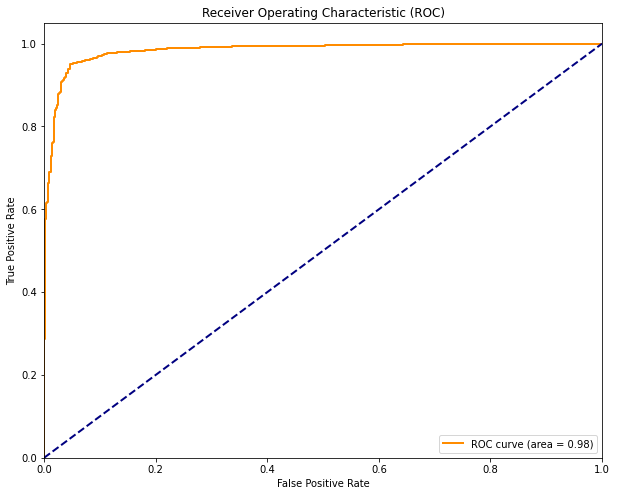

In [21]:
# draw ROC-AUC curve using true labels and predicted probabilities
y_proba=model.predict_proba(X_test)
draw_roc_auc(y_test,y_proba[:,1])

Accuracy: 0.949
Precision: 0.9481
Recall: 0.953
F1 Score: 0.9505


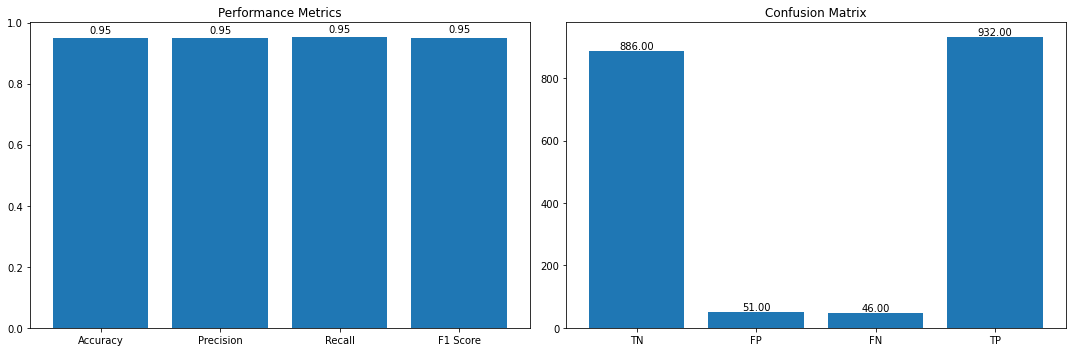

In [22]:
calculate_metrics(y_test, y_pred,'LogisticRegression')

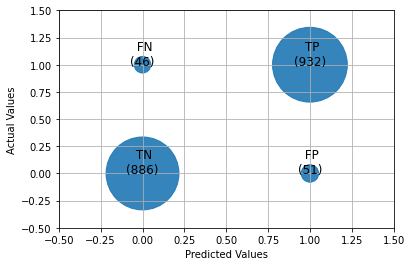

In [23]:
#Another way to visualise confusion matrix, the size represents the number of instances
plot_cf(y_pred,y_test)

In [24]:
# print the top 10 features based on their coefficients
print(top_10_features(model.coef_))

Index(['ratio_extredirection', 'google_index', 'domain_age', 'nb_hyperlinks',
       'ratio_digits_host', 'nb_qm', 'nb_www', 'page_rank', 'nb_hyphens',
       'phish_hints'],
      dtype='object')


In [25]:
#KNN

In [26]:
# It has been explained in our class that "The most preferred value for K is 5",
#but we are using grid search(hyper parameter tuning technique)  to 
#find the best K for our dataset

In [27]:
knn = KNeighborsClassifier()


param_grid = {'n_neighbors': range(1, 20)}

#we are using f1 score as scoring metric since, our usecase needs to balance both precision and recall
#predicting a legitimate site as Phishing (FN) and a Phishing site as legitimate(FP) are both equally costly 
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')


grid_search.fit(X_train, y_train)


print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best score: {grid_search.best_score_}")


Best K: 5
Best score: 0.9293137617529726


In [28]:
grid_search.cv_results_['param_n_neighbors']

masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object)

In [29]:
grid_search.cv_results_['mean_test_score']

array([0.92541198, 0.91175912, 0.92843443, 0.92550238, 0.92931376,
       0.92680589, 0.92571974, 0.92418537, 0.92454878, 0.92613909,
       0.92635455, 0.92573662, 0.92525137, 0.92411475, 0.92393518,
       0.92331783, 0.92362129, 0.92305956, 0.92181162])

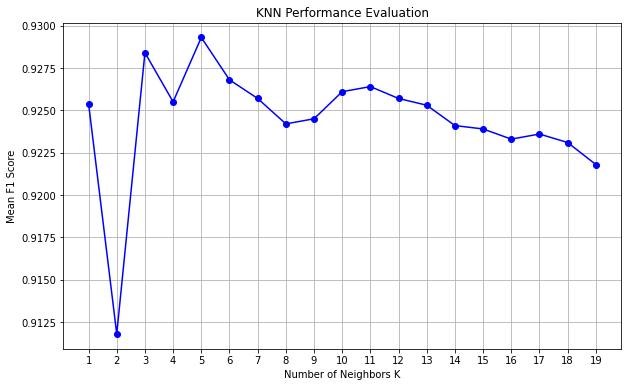

In [30]:
mean_f1_scores = list(map(lambda i:round(i,4),grid_search.cv_results_['mean_test_score']))

plt.figure(figsize=(10, 6))
plt.plot(range(1,20), mean_f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean F1 Score')
plt.title('KNN Performance Evaluation')
plt.grid(True)
plt.xticks(range(1,20))
plt.show()


In [31]:
#on testing data
# We are choosing n_neighbors = 5 since it had the highest F1 score 

Accuracy: 0.928
Precision: 0.9127
Recall: 0.9509
F1 Score: 0.9314


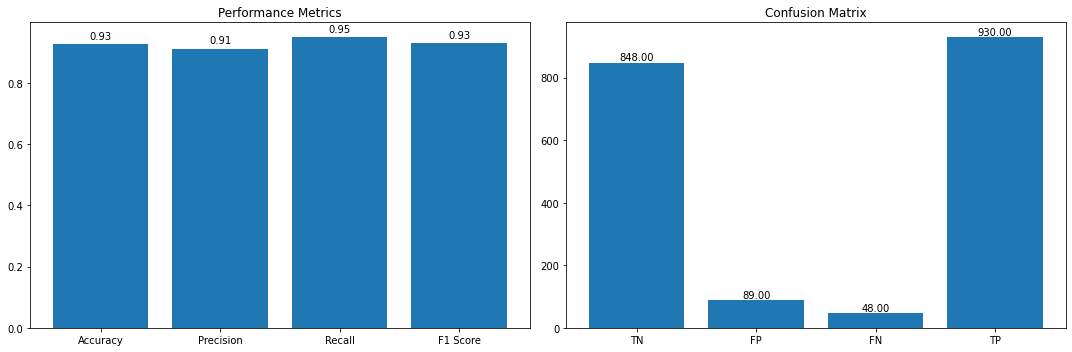

In [85]:
# create a KNN classifier with the best value of k
knn_with_best_k = KNeighborsClassifier(n_neighbors=5)
knn_with_best_k.fit(X_train, y_train)
y_pred = knn_with_best_k.predict(X_test)
calculate_metrics(y_test,y_pred,'KNN-5')

In [107]:
X_test.iloc[6].values.reshape(X_test.iloc[6].values.reshape(len(X_test.iloc[6].values),-1),-1)

TypeError: only integer scalar arrays can be converted to a scalar index

In [116]:
pd.set_option('display.max_columns', None)
def display_nearest_neighbors(X_test, y_test, y_pred, indices_misclassified):
    for index in indices_misclassified:
        print(index)
        test_instance = X_test.iloc[6].values.reshape(-1,len(X_test.iloc[6].values))
        true_label = y_test.iloc[index]
        predicted_label = y_pred[index]
        
        # Find the nearest neighbors for this test instance
        distances, indices = knn_with_best_k.kneighbors(test_instance)
        
        print(f"Test Instance Index: {index}, True Label: {true_label}, Predicted Label: {predicted_label}")
        print("Nearest Neighbors' Indices in Training Set:", indices[0])
        print("Nearest Neighbors' Distances:", distances[0], "\n")


indices_misclassified = np.where(y_test != y_pred)[0]


display_nearest_neighbors(X_test, y_test, y_pred, indices_misclassified[:5])  

6
Test Instance Index: 6, True Label: 0, Predicted Label: 1
Nearest Neighbors' Indices in Training Set: [5987 5856 4488 5301 4665]
Nearest Neighbors' Distances: [0.63906195 0.63954725 0.68696972 0.75558718 0.76748546] 

9
Test Instance Index: 9, True Label: 0, Predicted Label: 1
Nearest Neighbors' Indices in Training Set: [5987 5856 4488 5301 4665]
Nearest Neighbors' Distances: [0.63906195 0.63954725 0.68696972 0.75558718 0.76748546] 

31
Test Instance Index: 31, True Label: 0, Predicted Label: 1
Nearest Neighbors' Indices in Training Set: [5987 5856 4488 5301 4665]
Nearest Neighbors' Distances: [0.63906195 0.63954725 0.68696972 0.75558718 0.76748546] 

39
Test Instance Index: 39, True Label: 1, Predicted Label: 0
Nearest Neighbors' Indices in Training Set: [5987 5856 4488 5301 4665]
Nearest Neighbors' Distances: [0.63906195 0.63954725 0.68696972 0.75558718 0.76748546] 

85
Test Instance Index: 85, True Label: 0, Predicted Label: 1
Nearest Neighbors' Indices in Training Set: [5987 5856

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X do

In [117]:
# select specific rows from the training set
X_train.iloc[[6,5987,5856,4488,5301,4665]]

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_slash,nb_colon,nb_semicolumn,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,shortening_service,nb_external_redirection,length_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_inthyperlinks,ratio_exthyperlinks,nb_extcss,ratio_extredirection,external_favicon,links_in_tags,ratio_intmedia,ratio_extmedia,popup_window,safe_anchor,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
4082,0.166031,0.057143,0.0,0.043478,0.000000,0.0,0.0,0.0,0.055556,0.148148,0.0,0.0,0.5,0.2,0.0,0.0,1.0,0.000000,0.000000,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.104762,0.052632,0.050,0.018367,0.114754,0.022358,0.034983,0.118421,0.026400,0.0,0.0,0.0,0.0,0.0,0.0,0.045718,0.929577,0.070423,0.0,0.033333,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043247,0.609057,0.000371,0.0,0.0,0.5
9981,0.083969,0.109524,0.0,0.086957,0.046512,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.017857,0.037037,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.047619,0.052632,0.075,0.034694,0.295082,0.014228,0.035644,0.263158,0.017000,0.0,0.0,0.0,0.0,0.0,0.0,0.057094,0.992481,0.007519,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.818182,0.0,1.0,1.0,0.0,0.042073,0.299674,0.003409,0.0,0.0,0.3
8769,0.076336,0.109524,0.0,0.086957,0.023256,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.019231,0.037037,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.038095,0.052632,0.075,0.034694,0.295082,0.012195,0.041188,0.263158,0.018667,0.0,0.0,0.0,0.0,0.0,0.0,0.041640,0.989691,0.010309,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.818182,0.0,1.0,1.0,0.0,0.041939,0.299984,0.003494,0.0,0.0,0.3
7063,0.085878,0.071429,0.0,0.086957,0.069767,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.057143,0.052632,0.075,0.018367,0.163934,0.016260,0.028289,0.157895,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.060099,0.989286,0.010714,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.906250,0.0,1.0,1.0,0.0,0.015321,0.304956,0.001191,0.0,0.0,0.4
4446,0.030534,0.071429,0.0,0.043478,0.000000,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.009524,0.052632,0.000,0.018367,0.163934,0.000000,0.039604,0.157895,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.039279,1.000000,0.000000,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.000872,0.139894,0.062043,0.0,0.0,0.2
7367,0.034351,0.080952,0.0,0.043478,0.000000,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.009524,0.052632,0.000,0.022449,0.196721,0.000000,0.047525,0.184211,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.059455,0.992780,0.007220,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.750000,0.0,1.0,1.0,0.0,0.001106,0.195976,0.307274,0.0,0.0,0.2


In [121]:
test_instance = X_train.iloc[6]
neighbors = X_train.iloc[[5987, 5856, 4488, 5301, 4665]]

neighbors_mean = neighbors.mean()
neighbors_std = neighbors.std()

all_same_cols=[]

print("Feature analysis between test instance and its neighbors:")
for col in neighbors.columns:
    print(f"{col}:")
    print(f"  Test Instance: {test_instance[col]}")
    print(f"  Neighbors Mean: {neighbors_mean[col]}")
    print(f"  Neighbors Std: {neighbors_std[col]}\n")
    
    if test_instance[col]==neighbors_mean[col]:
        all_same_cols.append(col)
print(all_same_cols)

Feature analysis between test instance and its neighbors:
length_url:
  Test Instance: 0.16603053435114498
  Neighbors Mean: 0.06221374045801527
  Neighbors Std: 0.02744378322480542

length_hostname:
  Test Instance: 0.05714285714285715
  Neighbors Mean: 0.08857142857142858
  Neighbors Std: 0.019518001458970667

ip:
  Test Instance: 0.0
  Neighbors Mean: 0.0
  Neighbors Std: 0.0

nb_dots:
  Test Instance: 0.043478260869565216
  Neighbors Mean: 0.06956521739130432
  Neighbors Std: 0.02381402423935504

nb_hyphens:
  Test Instance: 0.0
  Neighbors Mean: 0.027906976744186046
  Neighbors Std: 0.030321871652105346

nb_at:
  Test Instance: 0.0
  Neighbors Mean: 0.0
  Neighbors Std: 0.0

nb_qm:
  Test Instance: 0.0
  Neighbors Mean: 0.0
  Neighbors Std: 0.0

nb_and:
  Test Instance: 0.0
  Neighbors Mean: 0.0
  Neighbors Std: 0.0

nb_eq:
  Test Instance: 0.05555555555555555
  Neighbors Mean: 0.0
  Neighbors Std: 0.0

nb_slash:
  Test Instance: 0.14814814814814814
  Neighbors Mean: 0.03703703703

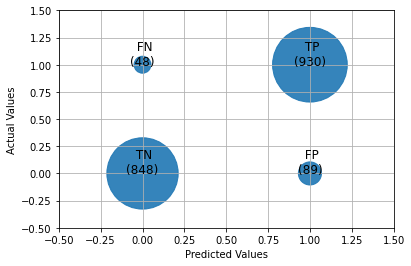

In [33]:
#Another way to visualise confusion matrix, the size represents the number of instances
plot_cf(y_pred,y_test)

In [89]:
knn_with_best_k.predict_proba(X_test)

array([[0. , 1. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0.8, 0.2],
       [0. , 1. ]])

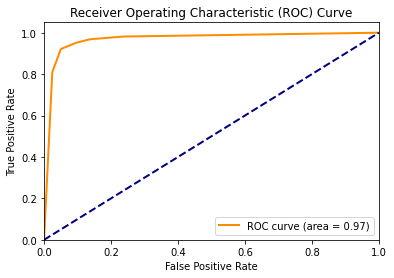

In [87]:
y_scores = knn_with_best_k.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
#DTREE

In [35]:
# we will use the random_state parameter will be used to break ties 
# using max_depth,min_samples_split to make sure it doesn't overfit
clf = DecisionTreeClassifier(criterion="entropy",random_state=10,min_samples_split=10,max_depth=10)

In [36]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [37]:
# New code
root_node_feature_index = clf.tree_.feature[0]  # Index of the feature used for splitting
root_node_threshold = clf.tree_.threshold[0]    # The threshold value for splitting

# to know which feature (by name) was used at the root
feature_names = X_train.columns 
root_node_feature_name = feature_names[root_node_feature_index]
print(root_node_feature_name,root_node_threshold)

google_index 0.5


In [78]:
#new code
# it is quite understandable as the google_index has highest correlation with is_legitimate
df.corr().loc["is_legitimate"].sort_values()

google_index              -0.729247
ratio_digits_url          -0.355951
domain_in_title           -0.336633
phish_hints               -0.329665
ip                        -0.313501
                             ...   
domain_age                 0.413662
nb_www                     0.436279
page_rank                  0.513371
is_legitimate              1.000000
nb_external_redirection         NaN
Name: is_legitimate, Length: 63, dtype: float64

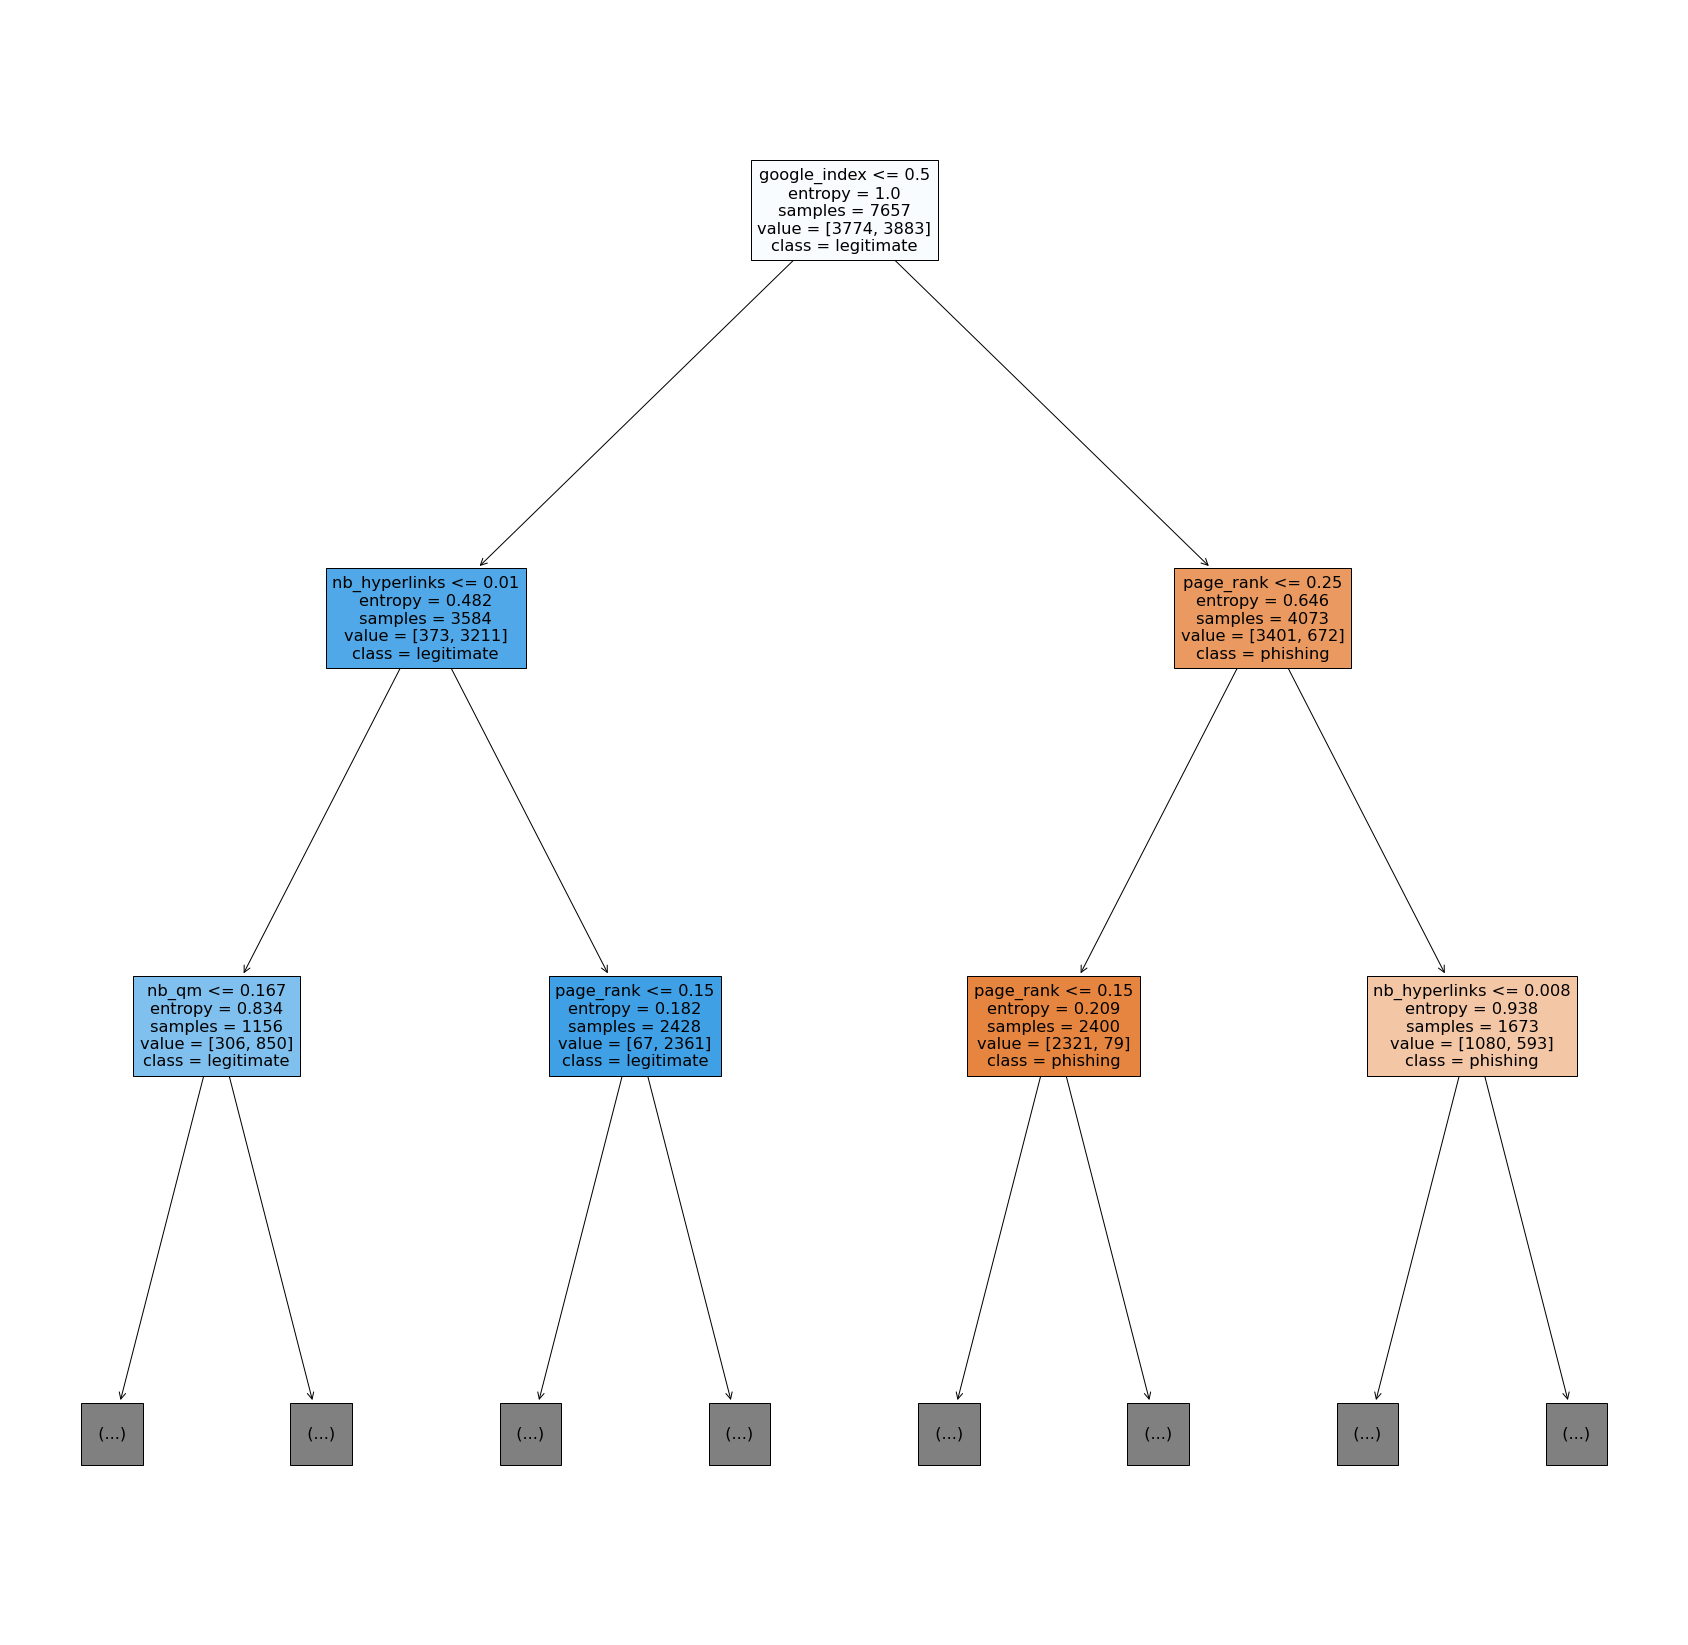

In [39]:
#new code
plt.figure(figsize=(30, 30))  
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['phishing','legitimate'],max_depth=2)
plt.savefig('decision_tree.png', format='png', bbox_inches='tight', dpi=300)  
# plt.show()


In [40]:
#showing that decision Trees inherently perform feature selection
# clf.feature_importances_ gives us the feature importances
feature_importances = clf.feature_importances_
feature_names = X_train.columns
features_and_importances = zip(feature_names, feature_importances)
# Removind all the features that are not used in the tree (importance > 0)
used_features = [(feature, importance) for feature, importance in features_and_importances if importance > 0]
if len(used_features) == len(feature_names):
    print("All features were used in making the tree.")
else:
    print("Not all features were used in making the tree. Num Features used:", len(used_features))

for feature, importance in used_features:
    print(f"Feature: {feature}, Importance: {importance}")

Not all features were used in making the tree. Num Features used: 38
Feature: length_url, Importance: 0.006500393074468556
Feature: length_hostname, Importance: 0.006359576930021799
Feature: nb_dots, Importance: 0.006161183482114057
Feature: nb_hyphens, Importance: 0.01013918743810203
Feature: nb_qm, Importance: 0.01946597867355997
Feature: nb_eq, Importance: 0.002244759195043108
Feature: nb_slash, Importance: 0.013645516082505686
Feature: nb_colon, Importance: 0.0011764767892150647
Feature: nb_www, Importance: 0.04132474841649714
Feature: ratio_digits_url, Importance: 0.004597620691182534
Feature: ratio_digits_host, Importance: 0.004136173209615025
Feature: nb_subdomains, Importance: 0.0008088388437977666
Feature: length_words_raw, Importance: 0.003028917287378501
Feature: shortest_word_host, Importance: 0.003485950563858853
Feature: shortest_word_path, Importance: 0.006570666970647106
Feature: longest_words_raw, Importance: 0.00843921365859065
Feature: longest_word_host, Importance: 

In [41]:
# total number of leaf nodes
np.sum(clf.tree_.feature==-2)

166

Accuracy: 0.947
Precision: 0.9424
Recall: 0.954
F1 Score: 0.9482


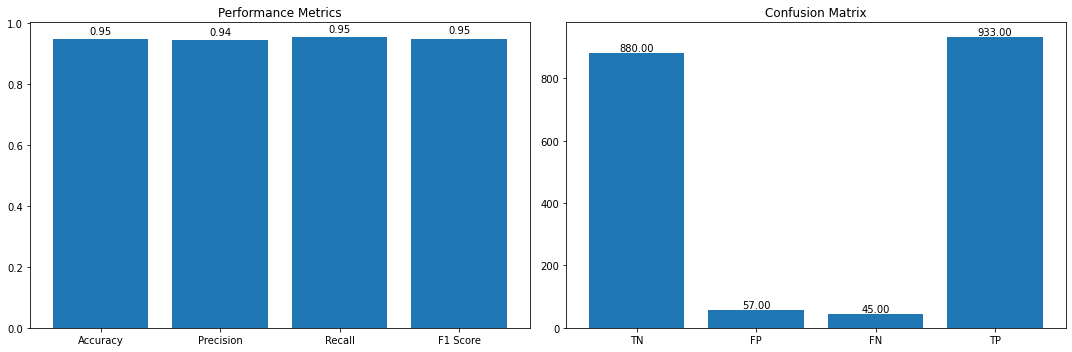

In [42]:
calculate_metrics(y_test,y_pred,'Decision Tree')

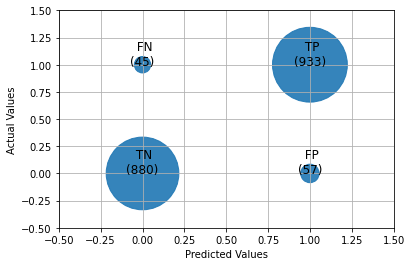

In [43]:
plot_cf(y_pred,y_test)

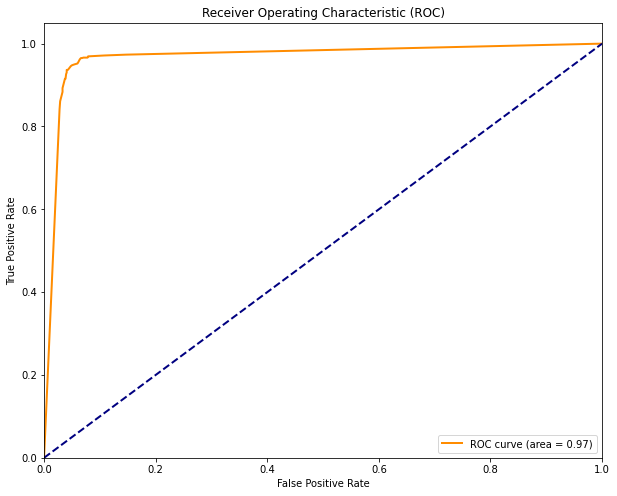

In [44]:
y_proba=clf.predict_proba(X_test)
draw_roc_auc(y_test,y_proba[:,1])

In [45]:
#NAIVE BAYES

In [46]:
#this is expected because the Naive bayes algorithm assumes all the features to be independent but in our case 
#most of the features are dependent on each other , The reason Recall to be high is that the model is doing a good
#job in predicting legitimate sites to be legitimate

#this model could have been very valuable to us if FN (predicting legitimate as phishing) were costlier than FP(predicting phishing as legitimate), 
#but in our case both are equall costly , so we consider F1 score

In [79]:
GaussianNB?

In [47]:
#  fitting the model on the training data
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.962
Precision: 0.9613
Recall: 0.9652
F1 Score: 0.9633


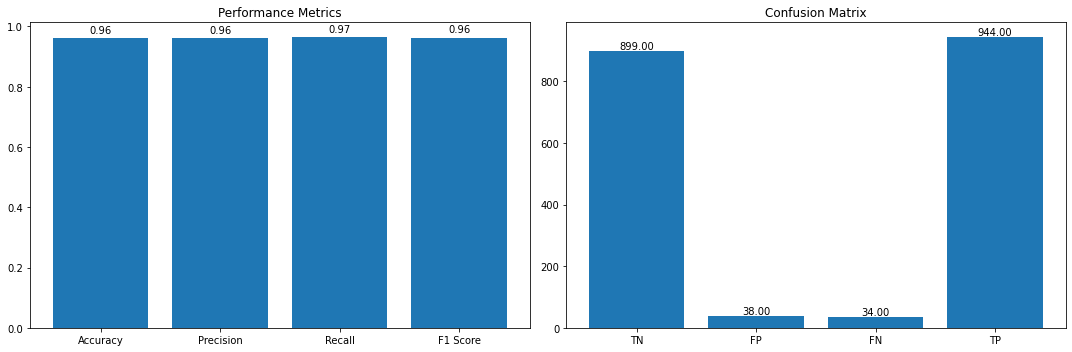

In [80]:
calculate_metrics(y_test,y_pred,'Guassian Naive Bayes')

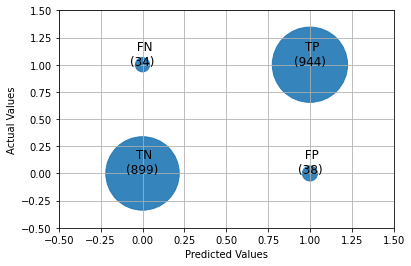

In [81]:
plot_cf(y_pred,y_test)

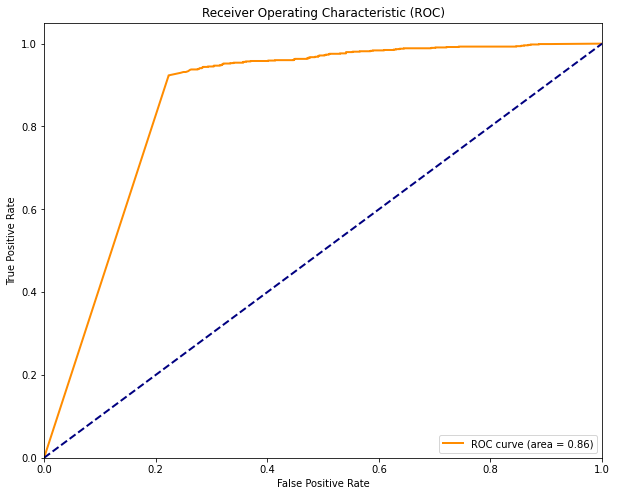

In [50]:
y_probs = model.predict_proba(X_test)[:, 1]
draw_roc_auc(y_test,y_probs)

In [51]:
#SVM
#linear SVM is giving us satisfactory scores for all our metrics including F1score, which implies that even though
#our data is high dimensional (60+ columns) the data is linearly separable or at least nearly linearly separable

Accuracy: 0.956
Precision: 0.9551
Recall: 0.9581
F1 Score: 0.9566


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


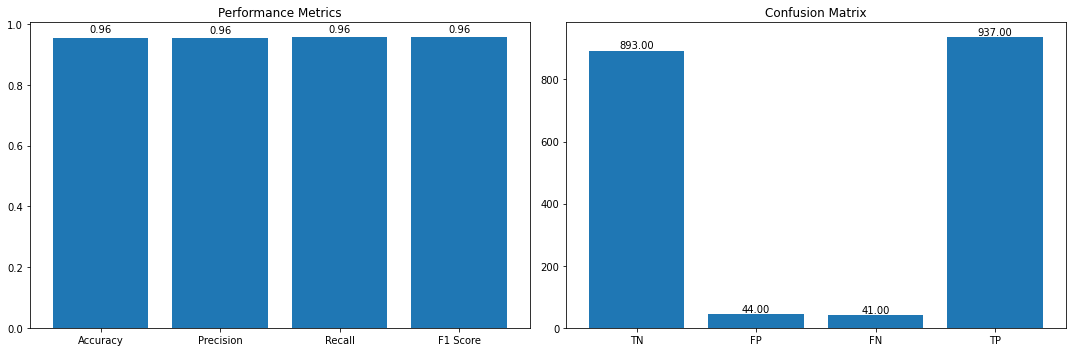

In [82]:
#  creating an instance of the linearSVC model with L1 regularization
linear_svc_with_lasso = LinearSVC(dual=False,penalty='l1',C=1.0)
#  fitting the model on the training data
linear_svc_with_lasso.fit(X_train, y_train)
# making predictions
y_pred=linear_svc_with_lasso.predict(X_test)
# calculating and printing evaluation metrics for the model
calculate_metrics(y_test,y_pred,'Linear SVM with lasso')

In [53]:
linear_svc = LinearSVC(dual=False,penalty='l2',C=1.0)  # dual=False for cases where n_samples > n_features
linear_svc.fit(X_train, y_train)

LinearSVC(dual=False)

In [54]:
y_pred=linear_svc.predict(X_test)

Accuracy: 0.955
Precision: 0.9541
Recall: 0.9571
F1 Score: 0.9556


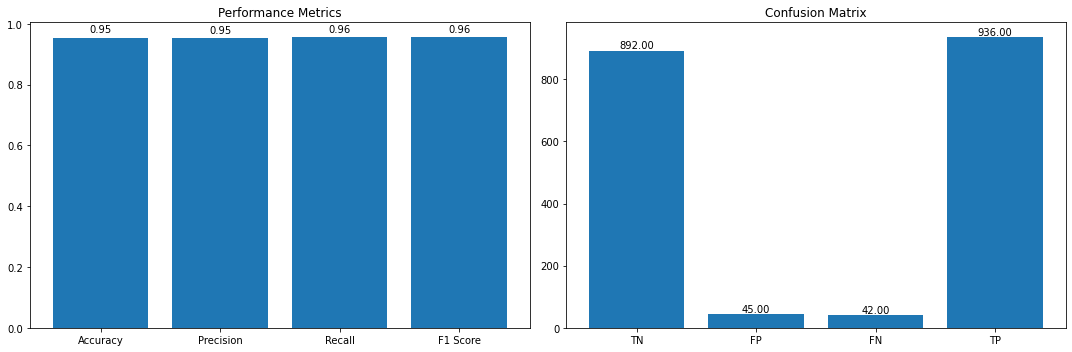

In [55]:
calculate_metrics(y_test,y_pred,'Linear SVM')

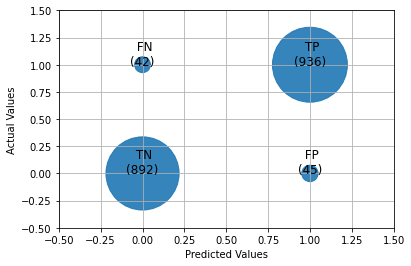

In [56]:
plot_cf(y_pred,y_test)

In [57]:
top_10_features(linear_svc.coef_)

Index(['length_words_raw', 'nb_semicolumn', 'ratio_digits_host', 'nb_dots',
       'longest_word_path', 'length_hostname', 'phish_hints',
       'longest_words_raw', 'nb_hyphens', 'nb_hyperlinks'],
      dtype='object')

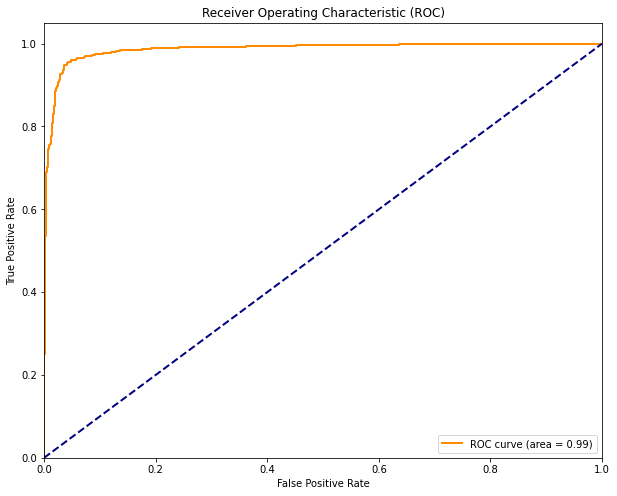

In [58]:
#gives out distance from each testing point to hyperplane
y_proba = linear_svc.decision_function(X_test)
draw_roc_auc(y_test,y_proba)

In [59]:
#Random Forest

In [60]:
#using max_depth to prevent. overfitting, n_estimators => the number of trees for estimation
rf= RandomForestClassifier(n_estimators=100, max_depth=10,random_state=11)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=11)

In [61]:
y_pred=rf.predict(X_test)

Accuracy: 0.962
Precision: 0.9613
Recall: 0.9652
F1 Score: 0.9633


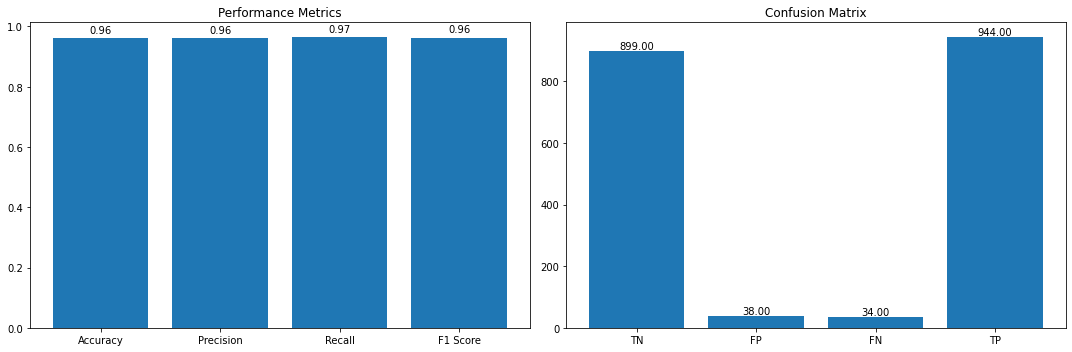

In [62]:
calculate_metrics(y_test,y_pred,'Random Forest')

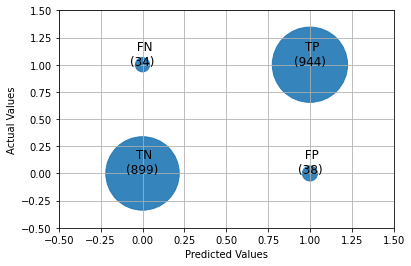

In [63]:
plot_cf(y_pred,y_test)

In [64]:
all_f1_scores

{'LogisticRegression': 0.9505354411014789,
 'KNN-5': 0.9313970956434652,
 'Decision Tree': 0.948170731707317,
 'Guassian Naive Bayes': 0.7918401332223147,
 'Linear SVM': 0.9555895865237367,
 'Random Forest': 0.963265306122449}

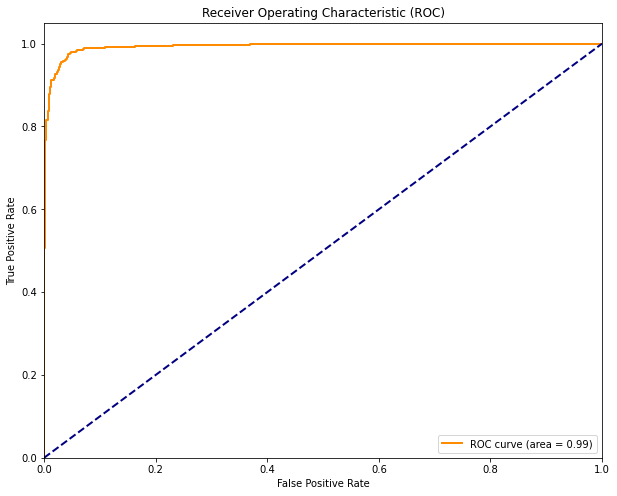

In [65]:
y_proba=rf.predict_proba(X_test)
draw_roc_auc(y_test,y_proba[:,1])

In [70]:
#Comparative analysis of models

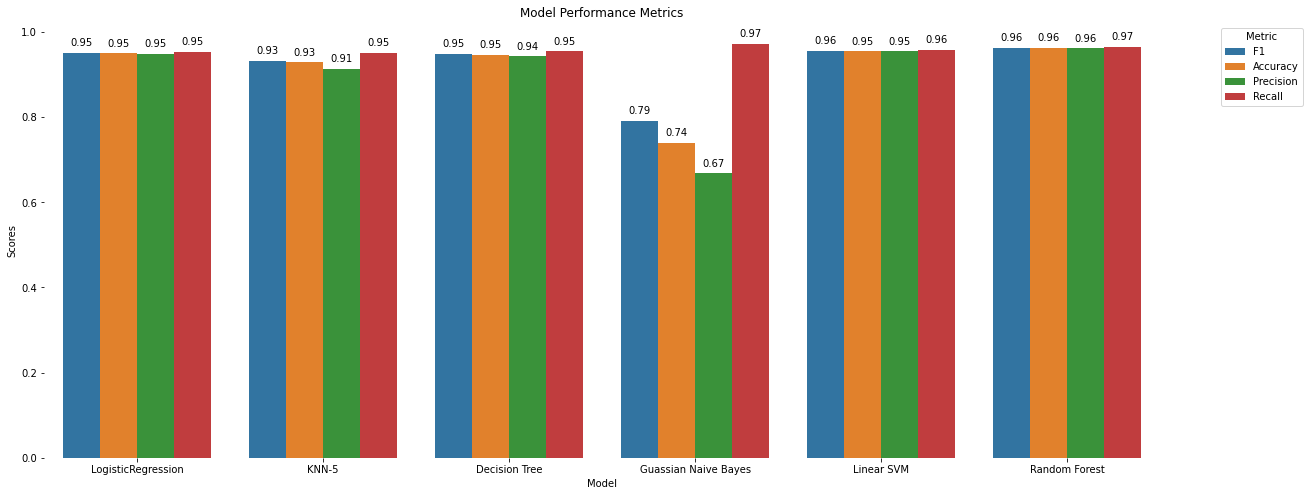

In [72]:
data = {
    'Model': list(all_f1_scores) * 4,
    'Score': list(all_f1_scores.values()) + list(all_accuracy_scores.values()) +
             list(all_precision_scores.values()) + list(all_recall_scores.values()),
    'Metric': ['F1'] * 6 + ['Accuracy'] * 6 + ['Precision'] * 6 + ['Recall'] * 6
}

df2 = pd.DataFrame(data)

plt.figure(figsize=(20, 8))
bar_plot = sns.barplot(data=df2, x='Model', y='Score', hue='Metric')


plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')


for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

plt.title('Model Performance Metrics')
plt.ylabel('Scores')
plt.xlabel('Model')
sns.despine(left=True, bottom=True)

plt.show()


In [73]:
#we are using f1 score as scoring metric since, our usecase needs to balance both precision and recall
#predicting a legitimate site as Phishing (FN) and a Phishing site as legitimate(FP) are both equally costly 

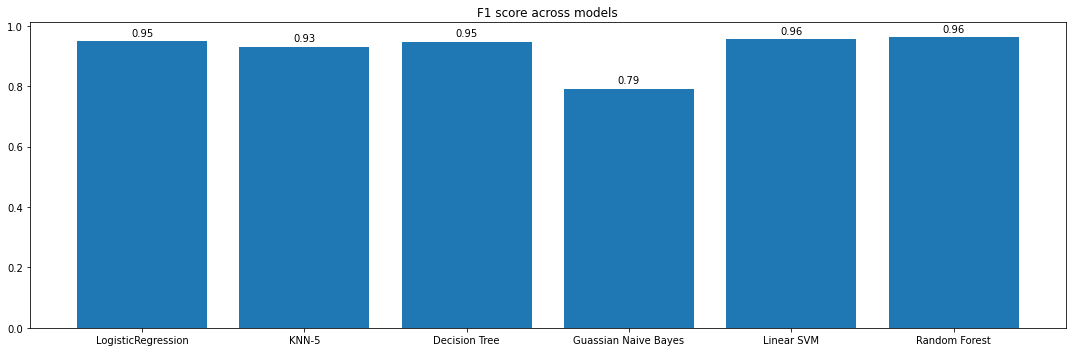

In [74]:
category_value_pairs = [(list(all_f1_scores.keys()),list(all_f1_scores.values()))]

plot_graphs(category_value_pairs,['F1 score across models'])

In [67]:
#we can see that "Linear SVM","Random Forest" gave us 96% f1 score,"Decision Tree" and "Logistic regression" 
#gave us an f1 score of 95%, KNN-5(with k=5)gave us an f1 score of 93% but Guassian Naive Bayes gave us only 79%

#we can conclude that SVM and Random Forest are the most efficient models for us.

In [77]:
# References for Random Forest classifier, Decision Tree

In [ ]:
# 1. https://scikit-learn.org/stable/modules/tree.html
# 2.https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html